In [ ]:
!pip install pytesseract
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,991 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from PIL import Image
import os
from google.colab import drive

# Connect Google Colab to Google Drive
drive.mount('/content/drive')

# Set up dataset path
dataset_dir = '/content/drive/My Drive/totalclasses/'


Mounted at /content/drive


Number of images: 5435, Number of labels: 5435


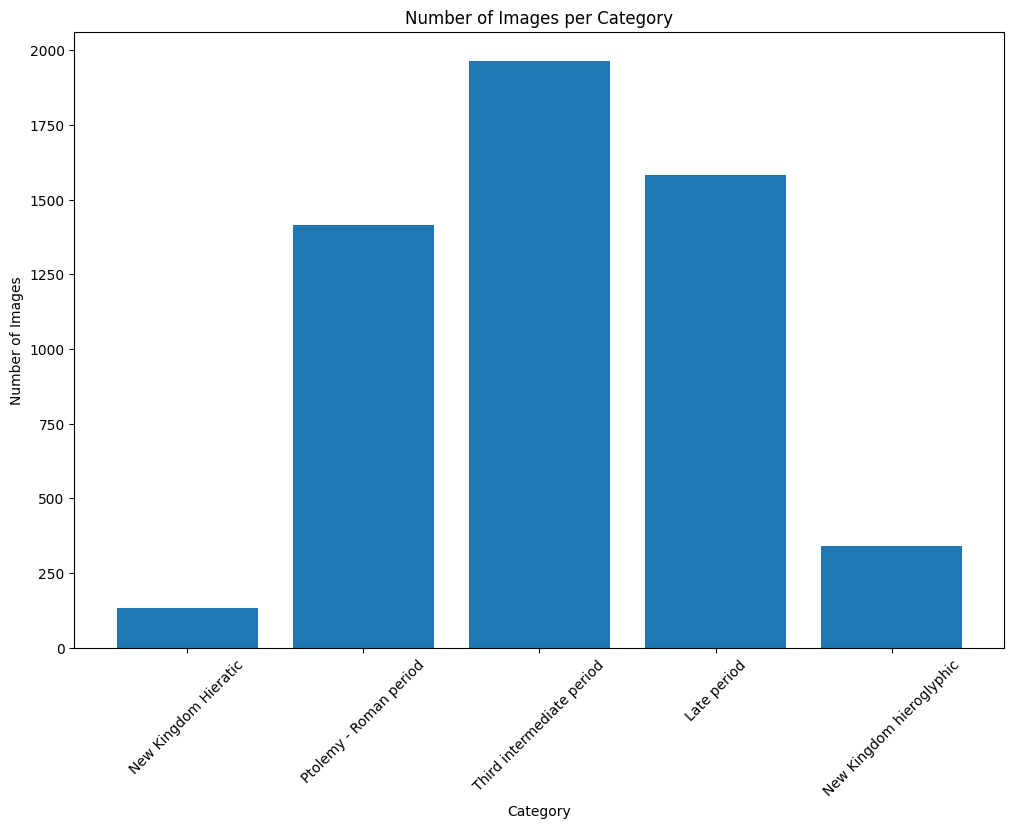

In [ ]:
# Collect image paths and categories
all_image_paths = []
all_labels = []
categories = os.listdir(dataset_dir)
num_classes = len(categories)
category_to_label = {category: idx for idx, category in enumerate(categories)}

for category in categories:
    category_dir = os.path.join(dataset_dir, category)
    if not os.path.isdir(category_dir):
        continue  # Ignore non-directory files

    for image_name in os.listdir(category_dir):
        image_path = os.path.join(category_dir, image_name)
        all_image_paths.append(image_path)
        all_labels.append(category_to_label[category])

# Check for consistency in list lengths
print(f'Number of images: {len(all_image_paths)}, Number of labels: {len(all_labels)}')

# Display names and number of images per category in a bar chart
category_counts = {category: 0 for category in categories}
for label in all_labels:
    category_name = categories[label]
    category_counts[category_name] += 1

plt.figure(figsize=(12, 8))
plt.bar(category_counts.keys(), category_counts.values())
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()



In [ ]:
# Split data into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels, test_size=0.2, random_state=42)


def preprocess_image_for_datagen(image_path, target_size=(224, 224)):
    image = Image.open(image_path)
    old_size = image.size
    ratio = float(target_size[0]) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    image = image.resize(new_size, Image.ANTIALIAS)
    new_image = Image.new("RGB", target_size)
    new_image.paste(image, ((target_size[0] - new_size[0]) // 2, (target_size[1] - new_size[1]) // 2))
    return np.array(new_image)


class CustomImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size, is_training):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.is_training = is_training
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.is_training:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_paths = [self.image_paths[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]

        batch_images = [preprocess_image_for_datagen(img_path) for img_path in batch_image_paths]
        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)

        return batch_images, batch_labels



In [ ]:
def build_model(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    model_input = Input(shape=input_shape)
    x = base_model(model_input)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=model_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
def extract_features(image_path):
    img = preprocess_image_for_datagen(image_path)
    img = np.expand_dims(img, axis=0)
    features = feature_extractor.predict(img)
    return features


input_shape = (224, 224, 3)
num_classes = len(categories)
model = build_model(input_shape, num_classes)
model.summary()

# Adding feature extractor
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)


16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                              

<ipython-input-4-a95da9652777>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(new_size, Image.ANTIALIAS)


Epoch 1/20
135/135 [==============================] - 1742s 13s/step - loss: 1.1739 - accuracy: 0.4856 - val_loss: 0.9630 - val_accuracy: 0.5881 - lr: 1.0000e-04
Epoch 2/20
135/135 [==============================] - 563s 4s/step - loss: 0.9554 - accuracy: 0.6028 - val_loss: 0.8509 - val_accuracy: 0.6562 - lr: 1.0000e-04
Epoch 3/20
135/135 [==============================] - 562s 4s/step - loss: 0.8503 - accuracy: 0.6604 - val_loss: 0.7833 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 4/20
135/135 [==============================] - 591s 4s/step - loss: 0.7781 - accuracy: 0.6944 - val_loss: 0.7384 - val_accuracy: 0.7150 - lr: 1.0000e-04
Epoch 5/20
135/135 [==============================] - 559s 4s/step - loss: 0.7286 - accuracy: 0.7220 - val_loss: 0.7055 - val_accuracy: 0.7292 - lr: 1.0000e-04
Epoch 6/20
135/135 [==============================] - 564s 4s/step - loss: 0.6902 - accuracy: 0.7317 - val_loss: 0.6850 - val_accuracy: 0.7339 - lr: 1.0000e-04
Epoch 7/20
135/135 [==================

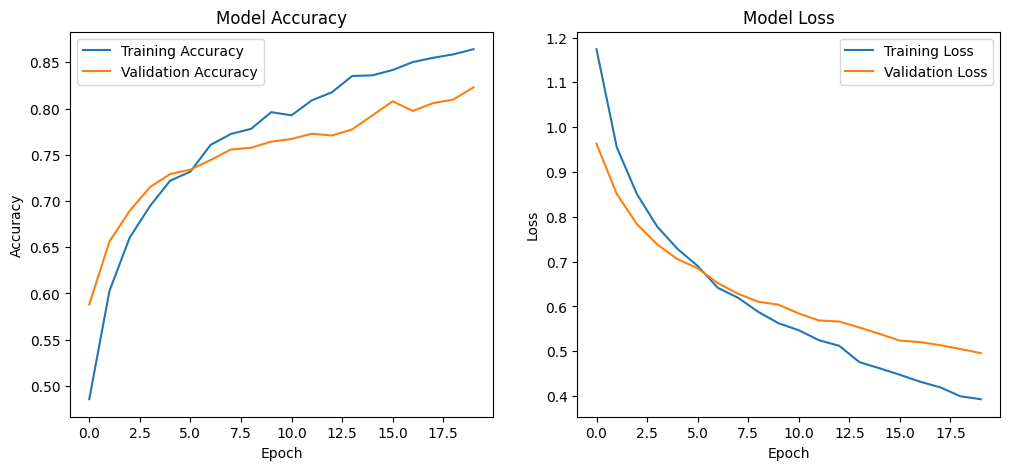

In [ ]:
# Training the model
batch_size = 32
train_generator = CustomImageDataGenerator(train_paths, train_labels, batch_size, is_training=True)
test_generator = CustomImageDataGenerator(test_paths, test_labels, batch_size, is_training=False)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)


# Evaluating the model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')

# Visualizing outputs in graphical form
# Plotting model accuracy during training and validation
plt.figure(figsize=(12, 5))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


<ipython-input-4-a95da9652777>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(new_size, Image.ANTIALIAS)


1/1 [==============================] - 2s 2s/step


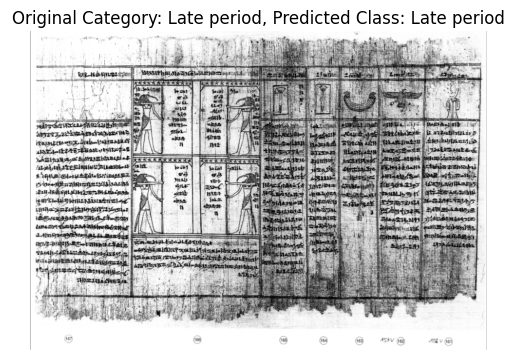

In [ ]:
# Using the model to predict a random image and displaying it
def predict_random_image():
    random_image_path = np.random.choice(all_image_paths)
    original_category = os.path.basename(os.path.dirname(random_image_path))
    img = preprocess_image_for_datagen(random_image_path)
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)

    plt.imshow(Image.open(random_image_path))
    plt.axis('off')
    plt.title(f'Original Category: {original_category}, Predicted Class: {categories[predicted_class]}')
    plt.show()

predict_random_image()